In [2]:
import os
import sys
import time
import random
import warnings

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K
from keras.utils import multi_gpu_model
from keras import optimizers
from sklearn.metrics import auc # roc curve toolsplt.hold(True)


# Specify Image Dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed

Using TensorFlow backend.


Function for computing the masks' pixel-to-pixel accuracy, takes as input 2D masks and 2D predictions
(Label 1 corresponds to skin, and 0 to non-skin)

Class for extracting time elapsed per training epoch

In [3]:
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback()

Intersection-over-Union (IoU) metric, can be tracked instead of the accuracy during training

In [4]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

A) Get the training data (original images + masks). The images and masks must have the same labelling. Add the original images' path to TRAIN_PATH, and the masks' path to MASK_PATH. 

In [5]:
# # #Dataset 1: HGR
# # TRAIN_PATH1 = ['../Input/Skin_Datasets/Dataset1_HGR/original_images/']
# # MASK_PATH1 = ['../Input/Skin_Datasets/Dataset1_HGR/skin_masks/']
# # train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
# # mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
# # train_ids1.sort()
# # mask_ids1.sort()
# # TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
# # MASK_PATH1 = MASK_PATH1*len(train_ids1)

# # # Dataset 2: TDSD
# # TRAIN_PATH5 = ['../Input/Skin_Datasets/Dataset2_TDSD/original_images/']
# # MASK_PATH5 = ['../Input/Skin_Datasets/Dataset2_TDSD/skin_masks/']
# # train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
# # mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
# # train_ids5.sort()
# # mask_ids5.sort()
# # TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
# # MASK_PATH5 = MASK_PATH5*len(train_ids5)

# # # Dataset 3: Schmugge
# # TRAIN_PATH6 = ['../Input/Skin_Datasets/Dataset3_Schmugge/original_images/']
# # MASK_PATH6 = ['../Input/Skin_Datasets/Dataset3_Schmugge/skin_masks/']
# # train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
# # mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
# # train_ids6.sort()
# # mask_ids6.sort()
# # TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
# # MASK_PATH6 = MASK_PATH6*len(train_ids6)

# # # # Dataset 4: Pratheepan
# # # TRAIN_PATH2 = ['../Input/Skin_Datasets/Dataset4_Pratheepan/original_images/']
# # # MASK_PATH2 = ['../Input/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
# # # train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
# # # mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
# # # train_ids2.sort()
# # # mask_ids2.sort()
# # # TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
# # # MASK_PATH2 = MASK_PATH2*len(train_ids2)

# # # Dataset 5: VDM
# # TRAIN_PATH3 = ['../Input/Skin_Datasets/Dataset5_VDM/original_images/']
# # MASK_PATH3 = ['../Input/Skin_Datasets/Dataset5_VDM/skin_masks/']
# # train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
# # mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
# # train_id3.sort()
# # mask_id3.sort()
# # train_ids3 = train_id3[1:]
# # mask_ids3 = mask_id3[1:]
# # TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
# # MASK_PATH3 = MASK_PATH3*len(train_ids3)

# # # Dataset 6: SFA
# # TRAIN_PATH4 = ['../Input/Skin_Datasets/Dataset6_SFA/original_images/']
# # MASK_PATH4 = ['../Input/Skin_Datasets/Dataset6_SFA/skin_masks/']
# # train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
# # mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
# # train_ids4.sort()
# # mask_ids4.sort()
# # TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
# # MASK_PATH4 = MASK_PATH4*len(train_ids4)

# # # Dataset 7: FSD
# # TRAIN_PATH7 = ['../Input/Skin_Datasets/Dataset7_FSD/original_images/']
# # MASK_PATH7 = ['../Input/Skin_Datasets/Dataset7_FSD/skin_masks/']
# # train_ids7 = next(os.walk(TRAIN_PATH7[0]))[2]
# # mask_ids7 = next(os.walk(MASK_PATH7[0]))[2]
# # train_ids7.sort()
# # mask_ids7.sort()
# # TRAIN_PATH7 = TRAIN_PATH7*len(train_ids7)
# # MASK_PATH7 = MASK_PATH7*len(train_ids7)

# # # ## Dataset 8: ABDOMEN
# # # TRAIN_PATH8 = ['../Input/Skin_Datasets/Dataset8_Abdomen/train/skin_train2019/']
# # # MASK_PATH8 = ['../Input/Skin_Datasets/Dataset8_Abdomen/train/annotations/']
# # # train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
# # # mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
# # # train_ids8.sort()
# # # mask_ids8.sort()

# # # TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
# # # MASK_PATH8 = MASK_PATH8*len(train_ids8)

# # ## Dataset 8: ABDOMEN_New
# TRAIN_PATH9 = ['../Input/Skin_Datasets/Dataset_NEW/original_images/']
# MASK_PATH9 = ['../Input/Skin_Datasets/Dataset_NEW/skin_masks/']
# train_ids9 = next(os.walk(TRAIN_PATH9[0]))[2]
# mask_ids9 = next(os.walk(MASK_PATH9[0]))[2]
# train_ids9.sort()
# mask_ids9.sort()

# TRAIN_PATH9 = TRAIN_PATH9*len(train_ids9)
# MASK_PATH9 = MASK_PATH9*len(train_ids9)

# # TRAIN_PATH2,MASK_PATH2,train_ids2,mask_ids2
# # Combine everything
# # TRAIN_PATH = np.concatenate((TRAIN_PATH1,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5, TRAIN_PATH6,TRAIN_PATH7)) #,TRAIN_PATH9
# # MASK_PATH = np.concatenate((MASK_PATH1,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6,MASK_PATH7))#,MASK_PATH9
# # train_ids = np.concatenate((train_ids1,train_ids3,train_ids4,train_ids5,train_ids6,train_ids7)) #,train_ids9
# # mask_ids = np.concatenate((mask_ids1,mask_ids3,mask_ids4,mask_ids5,mask_ids6,mask_ids7)) # ,mask_ids9

# TRAIN_PATH = TRAIN_PATH9
# MASK_PATH = MASK_PATH9
# train_ids = train_ids9
# mask_ids = mask_ids9

### B) Shuffle the data and resize

In [6]:
# X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
# print('Getting and resizing train images and masks ... ')
# sys.stdout.flush()
# g = list(range(0,len(train_ids)))
# np.random.shuffle(g)

# strs_original = ["" for x in range(len(train_ids))]
# strs_mask = ["" for x in range(len(train_ids))]
# pathmsk = MASK_PATH[0] + mask_ids[0]
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
#     strs_mask[n] = MASK_PATH[n] + mask_ids[n]
#     strs_original[n] = TRAIN_PATH[n] + train_ids[n]
    
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
#     path = strs_original[g[n]]
#     img = imread(path)[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_train[n] = img
    
#     path = strs_mask[g[n]]
# #     print(path)
#     img = imread(path)
#     if img.ndim == 3:
#         img = img[:,:,1]
#     img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
#     if (np.unique(img).size) > 2:
#         img = img > 30     # Important, needed to make labels 0's and 1's only 
#     else:
#         img = img > 0
#     Y_train[n] = img      

### To Avoid running the above two block again you can simply save the np arrays for convience by running the block below

In [7]:
# np.save("X_train_onlyabdomen",X_train)
# np.save("Y_train_onlyabdomen",Y_train)

In [8]:
# X_train = np.load('./X_data_abdomen_new.npy')
# Y_train = np.load('./Y_data_abdomen_new.npy')

In [9]:
X_train = np.load('./X_train_final.npy')
Y_train = np.load('./Y_train_final.npy')

In [10]:
# X_train = np.load('./X_train_withoutabdomen.npy')
# Y_train = np.load('./Y_train_withoutabdomen.npy')

C) Make sure the masks correspond to the original images

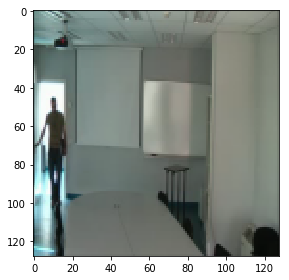

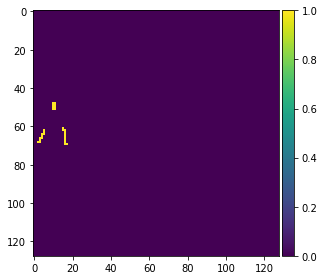

In [11]:
ix = random.randint(0, len(X_train))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

D) Construct the UNET model

In [11]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x/255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p5)
c6 = Dropout(0.3) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c5])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c4])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c3])
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c9)
u10 = concatenate([u10, c2], axis=3)
c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u10)
c10 = Dropout(0.1) (c10)
c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c10)

u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c10)
u11 = concatenate([u11, c1], axis=3)
c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u11)
c11 = Dropout(0.1) (c11)
c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c11)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c11)

model = Model(inputs=[inputs], outputs=[outputs])
model = multi_gpu_model(model, gpus=4)
optimize = optimizers.Adam(lr = 0.001,epsilon = 1e-8)
model.compile(optimizer=optimize, loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


E) Fit the model to the training data

In [ ]:
earlystopper = EarlyStopping(patience=30, verbose=1)
checkpointer = ModelCheckpoint('withabdomen.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.20, batch_size=64, epochs=208, shuffle=True, 
                    callbacks=[earlystopper, checkpointer, cb])

In [ ]:
a =results.history['val_acc']
b = results.history['val_loss']

F) Output training results

In [ ]:
# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('val loss min at '+ str(b.index(min(b)))+' : ' + str(min(b)))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('val accuracy max at '+ str(a.index(max(a)))+' : ' + str(max(a)))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
# print("UNET ARCHITECTURE")
# print ("-------------------------------------------------------------")
# print("Total num of training images: %d" % len(train_ids))
# print("Max num of epochs: %d" % 50)
# print("Optimizer: %s" % 'ADAM')
# print("Batch size: %d" % 64)
# print("Loss function: %s" % 'Binary Cross-Entropy')
# print("Validation data percentage: %d" % 10)
# # print("Early stoppping: %s" % 'Yes')

# a = results.history["acc"]
# b = results.history["loss"]
# c = results.history["val_acc"]
# d = results.history["val_loss"]
# e = cb.times
# print ("-------------------------------------------------------------")
# header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
# print(header)
# print ("-------------------------------------------------------------")
# for l in range(ep):
#     str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
#     print (str.expandtabs(2))
# print ("-------------------------------------------------------------")

G) Test against training and validation samples

In [ ]:
model = load_model('trainingonlr0.001.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.8):], verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

H) See predicted masks for training samples

In [ ]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

I) See predicted masks for validation data

In [ ]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.7):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.7):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

## J) Load model, testing data and check against trained network (if masks exist)

In [ ]:
# def acc_comp(msk, preds_test_t):
    
#     mean_acc = np.zeros(1)
#     mean_TP = np.zeros(1)
#     mean_TN = np.zeros(1)
#     mean_FP = np.zeros(1)
#     mean_FN = np.zeros(1)
    
#     for j in range(msk.shape[0]):
#         act = msk[j]
#         pr = preds_test_t[j].reshape(IMG_WIDTH, IMG_HEIGHT)
    
#         c = act == pr 
#         d = act & pr 
#         e = act | pr 
#         neg = act.sum()
#         pos = (IMG_WIDTH*IMG_HEIGHT)-act.sum()
    
#         TP = round(float(d.sum()),6)
#         FP = round(float(pr.sum()-d.sum()),6)
#         TN = round(float((IMG_WIDTH*IMG_HEIGHT)-e.sum()),6)
#         FN = round(float(e.sum()-pr.sum()),6)
#         acc = round(float(c.sum())/(IMG_WIDTH*IMG_HEIGHT),6)

#         #acc2 = float(TP+TN)/(TP+TN+FP+FN)  Used to double-check computations
#         mean_TP = np.append([mean_TP],TP)
#         mean_TN = np.append([mean_TN],TN)
#         mean_acc = np.append([mean_acc],acc)
#         mean_FP = np.append([mean_FP],FP)
#         mean_FN = np.append([mean_FN],FN)
    
#     mean_acc = mean_acc[1:]
#     mean_TP = mean_TP[1:]
#     mean_TN = mean_TN[1:]
#     mean_FP = mean_FP[1:]
#     mean_FN = mean_FN[1:]
    
#     avg = round(mean_acc.sum()/msk.shape[0],6)
#     std = round(np.std(mean_acc),6)
#     overall_TP = round(mean_TP.sum()/msk.shape[0],6)
#     overall_TN = round(mean_TN.sum()/msk.shape[0],6)
    
#     return (mean_acc,std,mean_TP,mean_TN,mean_FP,mean_FN)

In [14]:
# model = load_model('withabdomen.h5', custom_objects={'mean_iou': mean_iou})
# ABD_PATH = '../Input/Skin_Datasets/Test/FSD-ECU-100/original_images/'
# MSK_PATH = '../Input/Skin_Datasets/Test/FSD-ECU-100/skin_masks/'

ABD_PATH = '../Input/Skin_Datasets/Test/Abdomen-200/original_images/'
MSK_PATH = '../Input/Skin_Datasets/Test/Abdomen-200/skin_masks/'


abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
msk = np.zeros((len(msk_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img
    
for n, id_ in tqdm(enumerate(msk_ids), total=len(msk_ids)):
    path = MSK_PATH + id_
    img = imread(path)
    
    if img.ndim == 3:
        img = img[:,:,1]
        
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True)
    if (np.unique(img).size) > 2:
# ABD_PATH = '../Input/Skin_Datasets/Test/Pratheepan-78/original_images/'
# MSK_PATH = '../Input/Skin_Datasets/Test/Pratheepan-78/skin_masks/'

        img = img > 30           # Important, Needed to make labels 0's and 1's only   
    else:   
        img = img > 0
    img = img.astype(np.uint8)
    msk[n] = img
    

## Plotting ROC Curves

In [76]:
def getrates(msk, preds_test_t): #Takes as input 2D masks and 2D predictions

    mean_tpr = []
    mean_fpr = []
    mean_prec = []
    mean_rec = []
    for j in range(msk.shape[0]):
        act = msk[j]
        pr = preds_test_t[j].reshape(IMG_WIDTH, IMG_HEIGHT)
        c = act == pr #acc
        d = act & pr #true negative
        e = act | pr #true positive
        neg = act.sum()
        pos = (IMG_WIDTH*IMG_HEIGHT)-act.sum()
    
        TN = round(float(d.sum()),6)
        FN = round(float(pr.sum()-d.sum()),6)
        TP = round(float((IMG_WIDTH*IMG_HEIGHT)-e.sum()),6)
        FP = round(float(e.sum()-pr.sum()),6)

        tpr = float(TP)/(TP+FN)
        fpr = float(FP)/(FP+TN)
        prec = float(TP)/(TP+FP+0.0000001)
        rec = float(TP)/(TP+FN)
        
        
        mean_tpr.append(tpr)
        mean_fpr.append(fpr)
        mean_prec.append(prec)
        mean_rec.append(rec)
        
    return mean_tpr,mean_fpr, mean_prec, mean_rec

# Actual Predictions
def calcroc(model,abd,msk): 
    preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)
    threshs = np.linspace(0,1,11)
    TPR = []
    FPR=[]
    PREC=[]
    REC=[]
    for i in threshs:
        preds_test_t = (preds_test > i).astype(np.uint8)
        mean_tpr, mean_fpr, mean_prec, mean_rec = getrates(msk, preds_test_t);
        TPR.append(np.mean(mean_tpr))
        FPR.append(np.mean(mean_fpr))
        PREC.append(np.mean(mean_prec))
        REC.append(np.mean(mean_rec))
#     PREC.pop()
#     REC.pop()
    PREC= PREC[1:]
    REC= REC[1:]
    return TPR, FPR, PREC, REC

In [ ]:
modelabd_001 = load_model('afterlr0.001.h5', custom_objects={'mean_iou': mean_iou})
modelabd_002 = load_model('afterlr0.002.h5', custom_objects={'mean_iou': mean_iou})
modelnoabd = load_model('noabdomen0.001.h5', custom_objects={'mean_iou': mean_iou})

200/200 [==============================] - 0s 810us/step


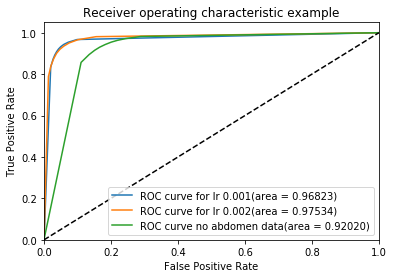

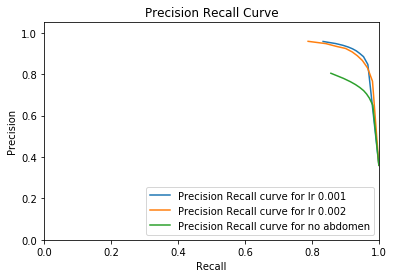

In [79]:
TPRabd_001, FPRabd_001, PRECabd_001, RECabd_001 = calcroc(modelabd_001,abd,msk)
TPRabd_002, FPRabd_002, PRECabd_002, RECabd_002 = calcroc(modelabd_002,abd,msk)
TPRnoabd, FPRnoabd, PRECnoabd, RECnoabd = calcroc(modelnoabd,abd,msk)

fig, ax = plt.subplots(1,1)
ax.plot(FPRabd_001, TPRabd_001, label='ROC curve for lr 0.001(area = %0.5f)' % auc(FPRabd_001,TPRabd_001))
ax.plot(FPRabd_002, TPRabd_002, label='ROC curve for lr 0.002(area = %0.5f)' % auc(FPRabd_002,TPRabd_002))
ax.plot(FPRnoabd, TPRnoabd, label='ROC curve no abdomen data(area = %0.5f)' % auc(FPRnoabd,TPRnoabd))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

fig, ax = plt.subplots(1,1)
ax.plot(RECabd_001, PRECabd_001, label='Precision Recall curve for lr 0.001')
ax.plot(RECabd_002, PRECabd_002, label='Precision Recall curve for lr 0.002')
ax.plot(RECnoabd, PRECnoabd, label='Precision Recall curve for no abdomen')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
ax.legend(loc="lower right")

### Getting Accuracy Values

In [ ]:
def acc_comp_anirudh(msk, preds_test_t): #Takes as input 2D masks and 2D predictions
    
    mean_acc = []
    mean_prec = []
    mean_rec = []
    mean_f = []
#     tp = []
#     tn = []
#     fp=[]
#     fn=[]
    FPR = []
    TPR= []
    for j in range(msk.shape[0]):
        act = msk[j]
        pr = preds_test_t[j].reshape(IMG_WIDTH, IMG_HEIGHT)
    
        c = act == pr #acc
        d = act & pr #true negative
        e = act | pr #true positive
        neg = act.sum()
        pos = (IMG_WIDTH*IMG_HEIGHT)-act.sum()
    
        TN = round(float(d.sum()),6)
        FN = round(float(pr.sum()-d.sum()),6)
        TP = round(float((IMG_WIDTH*IMG_HEIGHT)-e.sum()),6)
        FP = round(float(e.sum()-pr.sum()),6)
        acc = round(float(c.sum())/(IMG_WIDTH*IMG_HEIGHT),6)
    
        acc2 = float(TP+TN)/(TP+TN+FP+FN)
        prec = float(TP)/(TP+FP+0.0000000001)
        rec = float(TP)/(TP+FN)
        f_measure = 2*(prec*rec)/(prec+rec+0.0000000001)
        tpr = float(TP)/(TP+FN)
        fpr = float(FP)/(FP+TN)
        
        mean_acc.append(acc2)
        mean_prec.append(prec)
        mean_rec.append(rec)
        mean_f.append(f_measure)
        TPR.append(tpr)
        FPR.append(fpr)
        
#         tp.append(TP)
#         tn.append(TN)
#         fp.append(FP)
#         fn.append(FN)
        
        
    return mean_acc, mean_prec ,mean_rec, mean_f,TPR,FPR #tp ,tn, fp,fn

In [ ]:
# Actual Predictions
preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Overall accuracy on abdomen pictures
mean_accu, mean_prec,mean_rec, mean_f, TPR,FPR = acc_comp_anirudh(msk, preds_test_t);

avg = np.mean(mean_accu)
std = np.std(mean_accu)
precision = np.mean(mean_prec)
recall = np.mean(mean_rec)
fmeasure = np.mean(mean_f)
print("Accuracy " + str(avg))
print("STD Deviation " + str(std))
print("Precision " + str(precision))
print("Recall " + str(recall))
print("F-Measure " + str(fmeasure))

# # Save results in a .npy file
# a = np.reshape(answer[2],(100,1))
# b = np.reshape(answer[3],(100,1))
# c = np.reshape(answer[4],(100,1))
# d = np.reshape(answer[5],(100,1))
# g = np.concatenate([a,b,c,d],axis = 1)
# np.save('your_file_name.npy',g)

K) Visualize results

In [ ]:
for j in range(len(abd_ids)):
    print(j)
    plt.show()
    imshow(abd[j])
    plt.show()
    imshow(np.squeeze(preds_test_t[j]*255))
    plt.show()
    imshow(np.squeeze(msk[j]))

J') Load model, testing data and check against trained network (if masks do NOT exist)

In [ ]:
model = load_model('lydia.h5', custom_objects={'mean_iou': mean_iou})
ABD_PATH = '/home/lalzogbi/Documents/Umbilicus_Skin_Detection/code/wounds/'

abd_ids = next(os.walk(ABD_PATH))[2]
abd_ids.sort()

abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img
    
# Actual Predictions
preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

K') Visualize results

In [ ]:
for j in range(len(abd_ids)):
    print(j)
    plt.show()
    imshow(abd[j])
    plt.show()
    imshow(np.squeeze(preds_test_t[j]*255))
    plt.show()